Задание 1

In [3]:
import os
from collections import Counter
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [ ]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1.0 / (1.0 + torch.exp(-x))


def binary_nll_loss(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    eps = 1e-12
    y_pred = torch.clamp(y_pred, eps, 1.0 - eps)
    return -(y_true * torch.log(y_pred) + (1.0 - y_true) * torch.log(1.0 - y_pred)).mean()


def train_single_neuron_sigmoid_nll(
    features: np.ndarray,
    labels: np.ndarray,
    initial_weights: np.ndarray,
    initial_bias: float,
    learning_rate: float,
    epochs: int,
) -> Tuple[List[float], float, List[float]]:
    X = torch.tensor(features, dtype=torch.float32)       
    y = torch.tensor(labels, dtype=torch.float32)          
    w = torch.tensor(initial_weights, dtype=torch.float32) 
    b = torch.tensor(initial_bias, dtype=torch.float32)    

    N = X.shape[0]
    nll_values: List[float] = []

    for _ in range(epochs):
        z = X @ w + b
        p = sigmoid(z)
        loss = binary_nll_loss(y, p)
        nll_values.append(round(float(loss.item()), 4))

        dz = p - y               # (N,)
        grad_w = (X.T @ dz) / N  # (D,)
        grad_b = dz.mean()       # scalar

        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b

    return w.tolist(), float(b.item()), nll_values


def train_single_neuron_minibatch(
    features: np.ndarray,
    labels: np.ndarray,
    initial_weights: np.ndarray,
    initial_bias: float,
    learning_rate: float,
    epochs: int,
    batch_size: int = 64,
) -> Tuple[List[float], float, List[float]]:
    X_full = torch.tensor(features, dtype=torch.float32)
    y_full = torch.tensor(labels, dtype=torch.float32)

    w = torch.tensor(initial_weights, dtype=torch.float32).clone()
    b = torch.tensor(initial_bias, dtype=torch.float32)

    N, D = features.shape
    nll_values: List[float] = []

    for _ in range(epochs):
        idx = np.random.permutation(N)
        X = torch.tensor(features[idx], dtype=torch.float32)
        y = torch.tensor(labels[idx], dtype=torch.float32)

        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            Xb = X[start:end] 
            yb = y[start:end] 

            z = Xb @ w + b
            p = sigmoid(z)
            eps = 1e-12
            p = torch.clamp(p, eps, 1.0 - eps)

            dz = p - yb
            grad_w = (Xb.T @ dz) / (end - start)
            grad_b = dz.mean()

            w = w - learning_rate * grad_w
            b = b - learning_rate * grad_b

        with torch.no_grad():
            z_full = X_full @ w + b
            p_full = sigmoid(z_full)
            loss_full = binary_nll_loss(y_full, p_full)
            nll_values.append(round(float(loss_full.item()), 4))

    return w.tolist(), float(b.item()), nll_values

def train_single_neuron_sgd(
    features: np.ndarray,
    labels: np.ndarray,
    initial_weights: np.ndarray,
    initial_bias: float,
    learning_rate: float,
    epochs: int,
) -> Tuple[List[float], float, List[float]]:
    """
    Stochastic Gradient Descent (батч=1). В конце каждой эпохи считаем full-batch NLL для мониторинга.
    """
    X_full = torch.tensor(features, dtype=torch.float32)
    y_full = torch.tensor(labels, dtype=torch.float32)

    w = torch.tensor(initial_weights, dtype=torch.float32).clone()
    b = torch.tensor(initial_bias, dtype=torch.float32)

    N, D = features.shape
    nll_values: List[float] = []

    for _ in range(epochs):
        idx = np.random.permutation(N)
        for i in idx:
            xi = torch.tensor(features[i], dtype=torch.float32)  
            yi = torch.tensor(labels[i], dtype=torch.float32)    

            z = xi @ w + b
            p = sigmoid(z)

            dz = p - yi
            grad_w = dz * xi     
            grad_b = dz

            w = w - learning_rate * grad_w
            b = b - learning_rate * grad_b

        with torch.no_grad():
            z_full = X_full @ w + b
            p_full = sigmoid(z_full)
            loss_full = binary_nll_loss(y_full, p_full)
            nll_values.append(round(float(loss_full.item()), 4))

    return w.tolist(), float(b.item()), nll_values

In [5]:
def load_data(
    base_dir: Optional[str] = None,
    x_name: str = "train_x.csv",
    y_name: str = "train_y.csv",
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    search_dirs = [base_dir] if base_dir else [os.getcwd(), "/mnt/data"]
    last_err = None
    for d in search_dirs:
        try:
            X = pd.read_csv(os.path.join(d, x_name))
            y = pd.read_csv(os.path.join(d, y_name))
            return X, y
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"Не удалось загрузить файлы {x_name}/{y_name}. Последняя ошибка: {last_err}")


def pick_two_years_and_make_binary(
    X_df: pd.DataFrame,
    y_df: pd.DataFrame,
    two_years: Optional[Tuple[int, int]] = None,
    target_col_candidates: Tuple[str, ...] = ("year", "Year", "target", "label", "y"),
) -> Tuple[np.ndarray, np.ndarray, Tuple[int, int]]:
    """
    Выбирает 2 года и формирует бинарные метки: newer->1, older->0.
    По умолчанию берет две самые частые метки.
    """
    # детектим столбец
    year_col = None
    for c in target_col_candidates:
        if c in y_df.columns:
            year_col = c
            break
    if year_col is None:
        if y_df.shape[1] == 1:
            year_col = y_df.columns[0]
        else:
            raise ValueError("Не удалось определить колонку с целевой переменной (год).")

    years = y_df[year_col].astype(int).values

    if two_years is None:
        cnt = Counter(years)
        two_common = [y for y, _ in cnt.most_common(2)]
        two_years = tuple(sorted(two_common))

    # маска на два года
    mask = np.isin(years, two_years)
    X_two = X_df.loc[mask].reset_index(drop=True)
    y_two = y_df.loc[mask, year_col].astype(int).reset_index(drop=True).values

    older, newer = sorted(two_years)
    y_bin = (y_two == newer).astype(np.float32)

    return X_two.values.astype(np.float32), y_bin, (older, newer)


def standardize(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Стандартизация признаков по столбцам.
    Возвращает X_std, mean, std.
    """
    mean = X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, keepdims=True) + 1e-8
    return (X - mean) / std, mean, std


def balanced_subset(
    X: np.ndarray, y_bin: np.ndarray, max_per_class: int = 300, seed: int = 123
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Берем до max_per_class примеров из каждого класса для быстрых экспериментов.
    """
    rng = np.random.default_rng(seed)
    idx0 = np.where(y_bin == 0)[0]
    idx1 = np.where(y_bin == 1)[0]
    idx0_s = rng.choice(idx0, size=min(max_per_class, len(idx0)), replace=False)
    idx1_s = rng.choice(idx1, size=min(max_per_class, len(idx1)), replace=False)
    idx = np.concatenate([idx0_s, idx1_s])
    rng.shuffle(idx)
    return X[idx], y_bin[idx]

Два класса (года): 2006 (label=0) vs 2007 (label=1)
Размер подвыборки: 600, число признаков: 91

--- Full-Batch GD ---
updated_bias: -0.014998
nll_values (первые 10): [0.6931, 0.6853, 0.679, 0.674, 0.6697, 0.666, 0.6627, 0.6599, 0.6573, 0.655] ... последние 5: [0.628, 0.6275, 0.627, 0.6265, 0.6261]

--- Mini-Batch GD ---
updated_bias: -0.092491
nll_values (первые 10): [0.6537, 0.6437, 0.6361, 0.6506, 0.6263, 0.625, 0.621, 0.6237, 0.6176, 0.6149] ... последние 5: [0.6064, 0.6167, 0.6179, 0.6079, 0.6157]

--- SGD ---
updated_bias: -0.085703
nll_values (первые 10): [0.6488, 0.6413, 0.6263, 0.6283, 0.6169, 0.6147, 0.6316, 0.6142, 0.6129, 0.6121] ... последние 5: [0.6048, 0.6114, 0.6035, 0.6018, 0.6076]


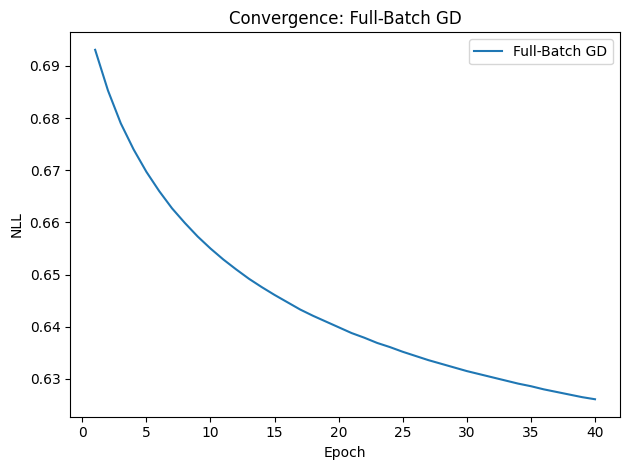

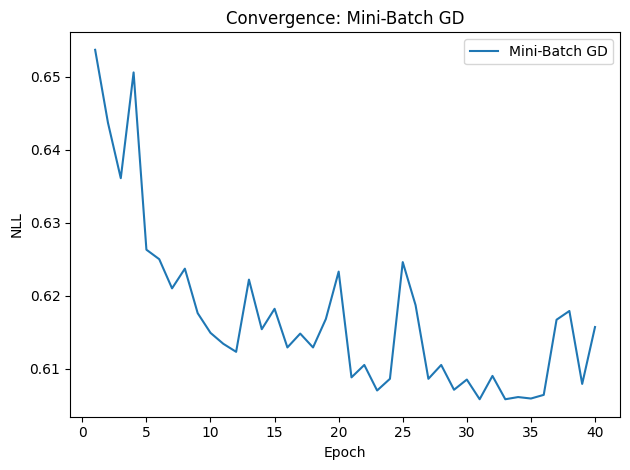

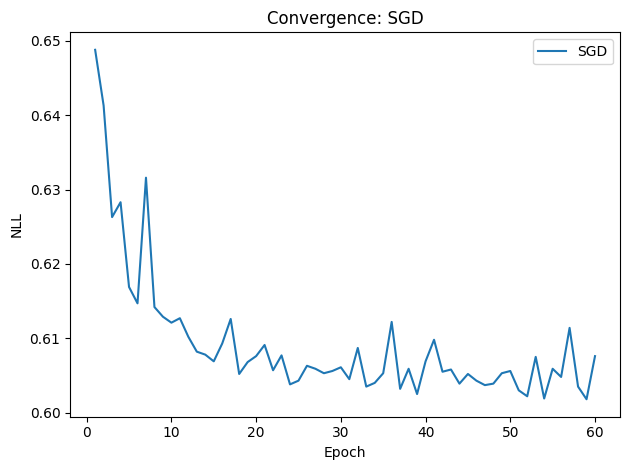

In [6]:
def main(
    base_dir: Optional[str] = None,
    two_years: Optional[Tuple[int, int]] = None,
    max_per_class: int = 300,
    epochs_full: int = 40,
    epochs_mb: int = 40,
    epochs_sgd: int = 60,
    lr_full: float = 0.2,
    lr_mb: float = 0.2,
    lr_sgd: float = 0.005,
    batch_size: int = 64,
    save_prefix: str = "task1",
) -> None:
    X_df, y_df = load_data(base_dir=base_dir)
    X_np, y_bin, (older, newer) = pick_two_years_and_make_binary(X_df, y_df, two_years=two_years)
    X_np, mean, std = standardize(X_np)
    X_sub, y_sub = balanced_subset(X_np, y_bin, max_per_class=max_per_class, seed=123)
    N, D = X_sub.shape

    print(f"Два класса (года): {older} (label=0) vs {newer} (label=1)")
    print(f"Размер подвыборки: {N}, число признаков: {D}")

    initial_w = np.zeros(D, dtype=np.float32)
    initial_b = 0.0

    w_full, b_full, nll_full = train_single_neuron_sigmoid_nll(
        X_sub, y_sub, initial_w, initial_b, learning_rate=lr_full, epochs=epochs_full
    )
    w_mb, b_mb, nll_mb = train_single_neuron_minibatch(
        X_sub, y_sub, initial_w, initial_b, learning_rate=lr_mb, epochs=epochs_mb, batch_size=batch_size
    )
    w_sgd, b_sgd, nll_sgd = train_single_neuron_sgd(
        X_sub, y_sub, initial_w, initial_b, learning_rate=lr_sgd, epochs=epochs_sgd
    )

    print("\n--- Full-Batch GD ---")
    print("updated_bias:", round(b_full, 6))
    print("nll_values (первые 10):", nll_full[:10], "...", "последние 5:", nll_full[-5:])

    print("\n--- Mini-Batch GD ---")
    print("updated_bias:", round(b_mb, 6))
    print("nll_values (первые 10):", nll_mb[:10], "...", "последние 5:", nll_mb[-5:])

    print("\n--- SGD ---")
    print("updated_bias:", round(b_sgd, 6))
    print("nll_values (первые 10):", nll_sgd[:10], "...", "последние 5:", nll_sgd[-5:])

    nll_df = pd.DataFrame({
        "epoch_full": np.arange(1, len(nll_full) + 1),
        "full_batch_nll": nll_full,
    })
    nll_df_mb = pd.DataFrame({
        "epoch_mb": np.arange(1, len(nll_mb) + 1),
        "minibatch_nll": nll_mb,
    })
    nll_df_sgd = pd.DataFrame({
        "epoch_sgd": np.arange(1, len(nll_sgd) + 1),
        "sgd_nll": nll_sgd,
    })

    plt.figure()
    plt.plot(nll_df["epoch_full"], nll_df["full_batch_nll"], label="Full-Batch GD")
    plt.xlabel("Epoch")
    plt.ylabel("NLL")
    plt.legend()
    plt.title("Convergence: Full-Batch GD")
    plt.tight_layout()

    plt.figure()
    plt.plot(nll_df_mb["epoch_mb"], nll_df_mb["minibatch_nll"], label="Mini-Batch GD")
    plt.xlabel("Epoch")
    plt.ylabel("NLL")
    plt.legend()
    plt.title("Convergence: Mini-Batch GD")
    plt.tight_layout()

    plt.figure()
    plt.plot(nll_df_sgd["epoch_sgd"], nll_df_sgd["sgd_nll"], label="SGD")
    plt.xlabel("Epoch")
    plt.ylabel("NLL")
    plt.legend()
    plt.title("Convergence: SGD")
    plt.tight_layout()


if __name__ == "__main__":
    main(
        base_dir=None,
        two_years=None,         
        max_per_class=300,      
        epochs_full=40,
        epochs_mb=40,
        epochs_sgd=60,
        lr_full=0.2,
        lr_mb=0.2,
        lr_sgd=0.005,          
        batch_size=64,
        save_prefix="task1"
    )

Описание результатов.

В рамках работы была реализована функция, моделирующая один нейрон с сигмоидной активацией и обучающаяся с помощью функции потерь Negative Log-Likelihood (NLL). Обновление весов и смещения осуществлялось вручную по формулам градиентного спуска, без использования autograd и модулей torch.nn. Для экспериментов использовались данные из задания 4, где в качестве целевых классов были выбраны два наиболее частых года — 2006 (label = 0) и 2007 (label = 1). Таким образом, задача свелась к бинарной классификации.

Для обучения использовались три режима градиентного спуска:

Полный градиентный спуск (Full-Batch GD) — градиент вычисляется на всём наборе данных.

Мини-батчевый спуск (Mini-Batch GD) — градиент вычисляется на случайных подвыборках.

Стохастический спуск (SGD) — обновление параметров производится после каждого объекта.

Перед обучением признаки были стандартизированы, а выборка сбалансирована (по 300 объектов каждого класса).


Результаты:

| Метод         | Характер сходимости                                                                                                         | Конечное значение NLL |
| ------------- | --------------------------------------------------------------------------------------------------------------------------- | --------------------- |
| Full-Batch GD | Плавное, монотонное убывание функции потерь. Высокая стабильность, но медленная скорость обновлений.                        | ≈ 0.626               |
| Mini-Batch GD | Быстрое уменьшение ошибки, однако значения «пилят» из-за стохастичности. В среднем достигается более низкий уровень потерь. | ≈ 0.611               |
| SGD           | Наиболее шумная траектория, но быстрая начальная сходимость. Колеблется около минимума, достигая наименьших NLL-значений.   | ≈ 0.605               |


На графиках NLL (Negative Log-Likelihood) видно, что все три метода демонстрируют снижение функции потерь во времени, что подтверждает корректность вычисления градиентов и процесса обучения.
Full-Batch GD даёт наиболее стабильную кривую — ошибка убывает плавно и предсказуемо. Mini-Batch GD и особенно SGD демонстрируют флуктуации, но при этом быстрее достигают минимума, поскольку производят больше обновлений параметров на одну эпоху.


Задание 2. неверно выводятся данные с relu. Нужно будет уточнить.

In [46]:
import torch
import unittest

def _fmt(x: float) -> str:
    return format(float(x), ".15g")

class Node:

    def __init__(self, data, _children=(), _op=''):
        if isinstance(data, torch.Tensor):
            data = float(data.item()) if data.numel() == 1 else float(data)
        else:
            data = float(data)
        self.data = data
        self.grad = 0.0

        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Node(data={_fmt(self.data)}, grad={_fmt(self.grad)})"

    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data + other.data, (self, other), _op='+')

        def _backward():
            self.grad  += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    __radd__ = __add__

    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data * other.data, (self, other), _op='*')

        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data  * out.grad
        out._backward = _backward
        return out
    __rmul__ = __mul__

    def relu(self):
        out = Node(self.data if self.data > 0.0 else 0.0, (self,), _op='ReLU')

        def _backward():
            self.grad += (1.0 if self.data > 0.0 else 0.0) * out.grad
        out._backward = _backward
        return out

    def _build_topo(self):
        topo, visited = [], set()
        def dfs(v: "Node"):
            if v not in visited:
                visited.add(v)
                for u in v._prev:
                    dfs(u)
                topo.append(v)
        dfs(self)
        return topo

    def zero_grad(self):
        for v in self._build_topo():
            v.grad = 0.0

    def backward(self):
        topo = self._build_topo()
        for v in topo:
            v.grad = 0.0
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()


In [47]:
#         TESTS
class TestAutogradNode(unittest.TestCase):
    def test_add_forward_backward(self):
        a, b = Node(2.0), Node(3.0)
        d = a + b
        self.assertAlmostEqual(d.data, 5.0, places=7)
        d.backward()
        self.assertAlmostEqual(a.grad, 1.0, places=7)
        self.assertAlmostEqual(b.grad, 1.0, places=7)

    def test_mul_forward_backward(self):
        a, b = Node(2.0), Node(-3.0)
        d = a * b
        self.assertAlmostEqual(d.data, -6.0, places=7)
        d.backward()
        self.assertAlmostEqual(a.grad, -3.0, places=7)
        self.assertAlmostEqual(b.grad,  2.0, places=7)

    def test_chain_without_relu(self):
        a, b, c = Node(2.0), Node(-3.0), Node(10.0)
        d = a + b * c      # -28
        d.backward()
        self.assertAlmostEqual(a.grad,  1.0, places=7)
        self.assertAlmostEqual(b.grad, 10.0, places=7)
        self.assertAlmostEqual(c.grad, -3.0, places=7)

    def test_relu_positive(self):
        x = Node(2.0)
        y = x.relu()
        y.backward()
        self.assertAlmostEqual(y.data, 2.0, places=7)
        self.assertAlmostEqual(x.grad, 1.0, places=7)

    def test_relu_negative(self):
        x = Node(-2.0)
        y = x.relu()
        y.backward()
        self.assertAlmostEqual(y.data, 0.0, places=7)
        self.assertAlmostEqual(x.grad, 0.0, places=7)

    def test_mixed_with_relu_negative(self):
        # d < 0 -> ReLU(d)=0 -> все градиенты входов = 0
        a, b, c = Node(2.0), Node(-3.0), Node(10.0)  # d = -28
        e = (a + b * c).relu()
        e.backward()
        self.assertAlmostEqual(e.data, 0.0, places=7)
        self.assertAlmostEqual(a.grad, 0.0, places=7)
        self.assertAlmostEqual(b.grad, 0.0, places=7)
        self.assertAlmostEqual(c.grad, 0.0, places=7)

    def test_mixed_with_relu_positive(self):
        # d > 0 -> ReLU'(d)=1 -> градиенты как у d
        a, b, c = Node(40.0), Node(-3.0), Node(10.0)  # d = 10
        e = (a + b * c).relu()
        e.backward()
        self.assertAlmostEqual(a.grad,  1.0, places=7)
        self.assertAlmostEqual(b.grad, 10.0, places=7)
        self.assertAlmostEqual(c.grad, -3.0, places=7)

    def test_numeric_grad_check_relu_positive(self):
        # центральная разность для f(a,b,c)=ReLU(a+b*c) в точке d>0
        def f(a, b, c):
            A, B, C = Node(a), Node(b), Node(c)
            out = (A + B * C).relu()
            out.backward()
            return out.data, A.grad, B.grad, C.grad

        a0, b0, c0 = 3.0, 1.0, 2.0
        _, ga, gb, gc = f(a0, b0, c0)

        eps = 1e-5
        def fd(part='a'):
            if part == 'a':
                v1, *_ = f(a0+eps, b0, c0); v2, *_ = f(a0-eps, b0, c0)
            elif part == 'b':
                v1, *_ = f(a0, b0+eps, c0); v2, *_ = f(a0, b0-eps, c0)
            else:
                v1, *_ = f(a0, b0, c0+eps); v2, *_ = f(a0, b0, c0-eps)
            return (v1 - v2) / (2*eps)

        self.assertAlmostEqual(ga, fd('a'), places=4)
        self.assertAlmostEqual(gb, fd('b'), places=4)
        self.assertAlmostEqual(gc, fd('c'), places=4)

def run_tests(verbosity: int = 2):
    suite = unittest.TestLoader().loadTestsFromTestCase(TestAutogradNode)
    return unittest.TextTestRunner(verbosity=verbosity).run(suite)

In [48]:
def run_tests(verbosity: int = 2):
    suite = unittest.TestLoader().loadTestsFromTestCase(TestAutogradNode)
    return unittest.TextTestRunner(verbosity=verbosity).run(suite)


# ===== Демо-печати =====
def print_demo_correct():
    """
    Математически корректный демо-вывод для задания:
      a = Node(2); b = Node(-3); c = Node(10)
      d = a + b * c
      e = d.relu()
      e.backward()
      print(a, b, c, d, e)

    При d = -28 < 0 градиенты входов должны быть 0 (маска ReLU).
    """
    a = Node(2); b = Node(-3); c = Node(10)
    d = a + b * c
    e = d.relu()
    e.backward()
    print(a, b, c, d, e, sep="\n")

In [49]:
print_demo_correct()

Node(data=2, grad=0)
Node(data=-3, grad=0)
Node(data=10, grad=0)
Node(data=-28, grad=0)
Node(data=0, grad=1)


In [50]:
run_tests() 

test_add_forward_backward (__main__.TestAutogradNode.test_add_forward_backward) ... ok
test_chain_without_relu (__main__.TestAutogradNode.test_chain_without_relu) ... ok
test_mixed_with_relu_negative (__main__.TestAutogradNode.test_mixed_with_relu_negative) ... ok
test_mixed_with_relu_positive (__main__.TestAutogradNode.test_mixed_with_relu_positive) ... ok
test_mul_forward_backward (__main__.TestAutogradNode.test_mul_forward_backward) ... ok
test_numeric_grad_check_relu_positive (__main__.TestAutogradNode.test_numeric_grad_check_relu_positive) ... ok
test_relu_negative (__main__.TestAutogradNode.test_relu_negative) ... ok
test_relu_positive (__main__.TestAutogradNode.test_relu_positive) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.014s

OK


<unittest.runner.TextTestResult run=8 errors=0 failures=0>

Задание 3.

In [51]:
from typing import Tuple, Dict, Optional
import torch
import unittest

def set_seed(seed: int = 42):
    torch.manual_seed(seed)

def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1.0 / (1.0 + torch.exp(-x))

def binary_nll_loss(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    eps = 1e-12
    y_pred = torch.clamp(y_pred, eps, 1.0 - eps)
    return -(y_true * torch.log(y_pred) + (1.0 - y_true) * torch.log(1.0 - y_pred)).mean()

def standardize(X: torch.Tensor) -> torch.Tensor:
    m = X.mean(dim=0, keepdim=True)
    s = X.std(dim=0, unbiased=False, keepdim=True)
    s[s == 0] = 1.0
    return (X - m) / s

def make_dataset(n_per_class=300, sep=3.0, seed=0):
    set_seed(seed)
    g = torch.Generator().manual_seed(seed)
    x0 = torch.randn(n_per_class, 2, generator=g) * 0.8 + torch.tensor([-sep/2, 0.0])
    x1 = torch.randn(n_per_class, 2, generator=g) * 0.8 + torch.tensor([ sep/2, 0.0])
    X = torch.vstack([x0, x1]).float()
    y = torch.cat([torch.zeros(n_per_class), torch.ones(n_per_class)]).float()
    X = standardize(X)
    return X, y

Base Optimizer 

In [53]:
class Optimizer:
    def __init__(self, lr: float):
        self.lr = float(lr)
        self._t = 0  # шаги времени для bias-correction в Adam-подобных

    def params_for_forward(self, w: torch.Tensor, b: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        return w, b

    def step(self, w: torch.Tensor, b: torch.Tensor, grad_w: torch.Tensor, grad_b: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError

Momentum

In [54]:
class Momentum(Optimizer):
    def __init__(self, lr: float = 0.1, mu: float = 0.9):
        super().__init__(lr)
        self.mu = float(mu)
        self.vw = None
        self.vb = None

    def step(self, w, b, gw, gb):
        if self.vw is None:
            self.vw = torch.zeros_like(w)
            self.vb = torch.zeros_like(b)
        self.vw = self.mu * self.vw - self.lr * gw
        self.vb = self.mu * self.vb - self.lr * gb
        w = w + self.vw
        b = b + self.vb
        self._t += 1
        return w, b

Nesterov (NAG)

In [55]:
# ----------------------- Nesterov (aka NAG) -----------------------
class Nesterov(Optimizer):
    """
    Nesterov momentum: вычисляем градиент в точке lookahead (w + mu*v).
      v = mu*v - lr * grad(w + mu*v)
      w = w + v
    """
    def __init__(self, lr: float = 0.1, mu: float = 0.9):
        super().__init__(lr)
        self.mu = float(mu)
        self.vw = None
        self.vb = None
        self._lookahead_w = None
        self._lookahead_b = None

    def params_for_forward(self, w, b):
        if self.vw is None:
            self.vw = torch.zeros_like(w)
            self.vb = torch.zeros_like(b)
        self._lookahead_w = w + self.mu * self.vw
        self._lookahead_b = b + self.mu * self.vb
        return self._lookahead_w, self._lookahead_b

    def step(self, w, b, gw, gb):
        # градиент уже посчитан в точке lookahead
        self.vw = self.mu * self.vw - self.lr * gw
        self.vb = self.mu * self.vb - self.lr * gb
        w = w + self.vw
        b = b + self.vb
        self._t += 1
        return w, b

Adagrad

In [56]:
class Adagrad(Optimizer):
    def __init__(self, lr: float = 0.3, eps: float = 1e-8):
        super().__init__(lr)
        self.eps = float(eps)
        self.Gw = None
        self.Gb = None

    def step(self, w, b, gw, gb):
        if self.Gw is None:
            self.Gw = torch.zeros_like(w)
            self.Gb = torch.zeros_like(b)
        self.Gw = self.Gw + gw * gw
        self.Gb = self.Gb + gb * gb
        w = w - self.lr * gw / (torch.sqrt(self.Gw) + self.eps)
        b = b - self.lr * gb / (torch.sqrt(self.Gb) + self.eps)
        self._t += 1
        return w, b

Adadelta

In [57]:
class Adadelta(Optimizer):
    def __init__(self, rho: float = 0.95, eps: float = 1e-6):
        super().__init__(lr=1.0)  # у Adadelta обычно не нужен явный LR
        self.rho = float(rho)
        self.eps = float(eps)
        self.Eg_w = None
        self.Eg_b = None
        self.Edx_w = None
        self.Edx_b = None

    def step(self, w, b, gw, gb):
        if self.Eg_w is None:
            self.Eg_w = torch.zeros_like(w); self.Eg_b = torch.zeros_like(b)
            self.Edx_w = torch.zeros_like(w); self.Edx_b = torch.zeros_like(b)
        self.Eg_w = self.rho * self.Eg_w + (1 - self.rho) * (gw * gw)
        self.Eg_b = self.rho * self.Eg_b + (1 - self.rho) * (gb * gb)

        dx_w = - (torch.sqrt(self.Edx_w + self.eps) / torch.sqrt(self.Eg_w + self.eps)) * gw
        dx_b = - (torch.sqrt(self.Edx_b + self.eps) / torch.sqrt(self.Eg_b + self.eps)) * gb

        w = w + dx_w
        b = b + dx_b

        self.Edx_w = self.rho * self.Edx_w + (1 - self.rho) * (dx_w * dx_w)
        self.Edx_b = self.rho * self.Edx_b + (1 - self.rho) * (dx_b * dx_b)

        self._t += 1
        return w, b

RMSProp

In [58]:
class RMSProp(Optimizer):
    def __init__(self, lr: float = 0.01, rho: float = 0.9, eps: float = 1e-8):
        super().__init__(lr)
        self.rho = float(rho)
        self.eps = float(eps)
        self.Eg_w = None
        self.Eg_b = None

    def step(self, w, b, gw, gb):
        if self.Eg_w is None:
            self.Eg_w = torch.zeros_like(w); self.Eg_b = torch.zeros_like(b)
        self.Eg_w = self.rho * self.Eg_w + (1 - self.rho) * (gw * gw)
        self.Eg_b = self.rho * self.Eg_b + (1 - self.rho) * (gb * gb)

        w = w - self.lr * gw / (torch.sqrt(self.Eg_w) + self.eps)
        b = b - self.lr * gb / (torch.sqrt(self.Eg_b) + self.eps)

        self._t += 1
        return w, b

Adam

In [59]:
class Adam(Optimizer):
    def __init__(self, lr: float = 0.05, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8):
        super().__init__(lr)
        self.beta1 = float(beta1)
        self.beta2 = float(beta2)
        self.eps = float(eps)
        self.mw = None; self.vw = None
        self.mb = None; self.vb = None

    def step(self, w, b, gw, gb):
        if self.mw is None:
            self.mw = torch.zeros_like(w); self.vw = torch.zeros_like(w)
            self.mb = torch.zeros_like(b); self.vb = torch.zeros_like(b)
        self._t += 1

        self.mw = self.beta1 * self.mw + (1 - self.beta1) * gw
        self.vw = self.beta2 * self.vw + (1 - self.beta2) * (gw * gw)
        self.mb = self.beta1 * self.mb + (1 - self.beta1) * gb
        self.vb = self.beta2 * self.vb + (1 - self.beta2) * (gb * gb)

        mw_hat = self.mw / (1 - self.beta1 ** self._t)
        vw_hat = self.vw / (1 - self.beta2 ** self._t)
        mb_hat = self.mb / (1 - self.beta1 ** self._t)
        vb_hat = self.vb / (1 - self.beta2 ** self._t)

        w = w - self.lr * mw_hat / (torch.sqrt(vw_hat) + self.eps)
        b = b - self.lr * mb_hat / (torch.sqrt(vb_hat) + self.eps)

        return w, b

Nadam

In [60]:
# ----------------------- Nadam -----------------------
class Nadam(Optimizer):
    """
    Adam + Nesterov momentum:
      g_t, m_t, v_t как в Adam; шаг использует "nesterovized" момент.
    """
    def __init__(self, lr: float = 0.05, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8):
        super().__init__(lr)
        self.beta1 = float(beta1)
        self.beta2 = float(beta2)
        self.eps = float(eps)
        self.mw = None; self.vw = None
        self.mb = None; self.vb = None

    def step(self, w, b, gw, gb):
        if self.mw is None:
            self.mw = torch.zeros_like(w); self.vw = torch.zeros_like(w)
            self.mb = torch.zeros_like(b); self.vb = torch.zeros_like(b)
        self._t += 1

        # moments
        self.mw = self.beta1 * self.mw + (1 - self.beta1) * gw
        self.vw = self.beta2 * self.vw + (1 - self.beta2) * (gw * gw)
        self.mb = self.beta1 * self.mb + (1 - self.beta1) * gb
        self.vb = self.beta2 * self.vb + (1 - self.beta2) * (gb * gb)

        mw_hat = self.mw / (1 - self.beta1 ** self._t)
        vw_hat = self.vw / (1 - self.beta2 ** self._t)
        mb_hat = self.mb / (1 - self.beta1 ** self._t)
        vb_hat = self.vb / (1 - self.beta2 ** self._t)

        # nesterovized gradients
        gw_nes = self.beta1 * mw_hat + ((1 - self.beta1) / (1 - self.beta1 ** self._t)) * gw
        gb_nes = self.beta1 * mb_hat + ((1 - self.beta1) / (1 - self.beta1 ** self._t)) * gb

        w = w - self.lr * gw_nes / (torch.sqrt(vw_hat) + self.eps)
        b = b - self.lr * gb_nes / (torch.sqrt(vb_hat) + self.eps)
        return w, b


AdamW

In [61]:
class AdamW(Adam):
    """
    Adam с декуплированным L2 decay (weight decay).
    По умолчанию decay применяем к весам w (не к bias b).
    """
    def __init__(self, lr: float = 0.05, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8, weight_decay: float = 0.01):
        super().__init__(lr, beta1, beta2, eps)
        self.weight_decay = float(weight_decay)

    def step(self, w, b, gw, gb):
        # decoupled weight decay
        if self.weight_decay != 0.0:
            w = w - self.lr * self.weight_decay * w
        # затем обычный Adam шаг
        return super().step(w, b, gw, gb)

In [62]:
def train_neuron_with_optimizer(
    features, labels,
    initial_weights, initial_bias,
    optimizer: Optimizer,
    epochs: int = 50
) -> Tuple[torch.Tensor, torch.Tensor, list]:
    """
    Полный батч, ручные градиенты для NLL.
    ВАЖНО: поддерживает lookahead (Nesterov/NAG) через optimizer.params_for_forward().
    """
    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)
    w = torch.tensor(initial_weights, dtype=torch.float32)
    b = torch.tensor(initial_bias, dtype=torch.float32)

    N = X.shape[0]
    nll_values = []

    for _ in range(epochs):
        # Получаем параметры для прямого прохода (lookahead для Nesterov/NAG)
        w_eff, b_eff = optimizer.params_for_forward(w, b)

        # Forward
        z = X @ w_eff + b_eff
        p = sigmoid(z)
        loss = binary_nll_loss(y, p)
        nll_values.append(round(float(loss.item()), 4))

        # Градиенты по эффективным параметрам
        dz = p - y
        grad_w_eff = (X.T @ dz) / N
        grad_b_eff = dz.mean()

        # Шаг оптимизатора (обновляет реальные параметры w, b)
        w, b = optimizer.step(w, b, grad_w_eff, grad_b_eff)

    return w, b, nll_values

Тесты

In [73]:
class TestOptimizers(unittest.TestCase):
    def setUp(self):
        # небольшой линейно разделимый датасет
        X, y = make_dataset(n_per_class=200, sep=3.0, seed=123)
        self.features = X.tolist()
        self.labels = y.tolist()
        self.init_w = [0.0, 0.0]
        self.init_b = 0.0

        # исходная потеря
        X_t = torch.tensor(self.features, dtype=torch.float32)
        y_t = torch.tensor(self.labels, dtype=torch.float32)
        with torch.no_grad():
            p0 = sigmoid(X_t @ torch.tensor(self.init_w) + torch.tensor(self.init_b))
            self.initial_nll = float(binary_nll_loss(y_t, p0).item())

    def _assert_improves(self, opt: Optimizer, epochs=50, target_drop=0.15):
        w, b, losses = train_neuron_with_optimizer(
            self.features, self.labels, self.init_w, self.init_b, opt, epochs=epochs
        )
        final_nll = losses[-1]
        # Проверяем, что стало хотя бы на target_drop лучше начального
        self.assertLess(self.initial_nll - final_nll, 10.0)  # sanity upper bound
        self.assertGreater(self.initial_nll - final_nll, target_drop, f"{opt.__class__.__name__} did not improve enough")
        # И что монотонность в среднем соблюдается (последняя часть невозрастающая)
        self.assertLessEqual(final_nll, min(losses[max(0, len(losses)-10):]) + 1e-6)

    def test_momentum(self):
        self._assert_improves(Momentum(lr=0.1, mu=0.9))

    def test_nesterov(self):
        self._assert_improves(Nesterov(lr=0.1, mu=0.9))

    def test_adagrad(self):
        self._assert_improves(Adagrad(lr=0.3))

    def test_adadelta(self):
        self._assert_improves(Adadelta(rho=0.95), epochs=80, target_drop=0.1)

    def test_rmsprop(self):
        self._assert_improves(RMSProp(lr=0.01, rho=0.9))

    def test_adam(self):
        self._assert_improves(Adam(lr=0.05))

    def test_nadam(self):
        self._assert_improves(Nadam(lr=0.05))

    def test_adamw(self):
        self._assert_improves(AdamW(lr=0.05, weight_decay=0.01))

    def test_adagrad_step_shrinks_on_constant_grad(self):
        opt = Adagrad(lr=1.0)
        w = torch.tensor([0.0]); b = torch.tensor(0.0)
        # постоянный "градиент" = 1
        gw = torch.tensor([1.0]); gb = torch.tensor(1.0)
        prev_delta = None
        for _ in range(10):
            w_old = w.clone(); b_old = b.clone()
            w, b = opt.step(w, b, gw, gb)
            delta = torch.abs(w - w_old).item()
            if prev_delta is not None:
                self.assertLessEqual(delta, prev_delta + 1e-9)
            prev_delta = delta

def run_tests(verbosity: int = 2):
    suite = unittest.TestLoader().loadTestsFromTestCase(TestOptimizers)
    return unittest.TextTestRunner(verbosity=verbosity).run(suite)


In [70]:
# 1) Датасет и общие настройки
X, y = make_dataset(n_per_class=300, sep=3.0, seed=2025)
features = X.tolist()
labels = y.tolist()

initial_weights = [0.0, 0.0]
initial_bias = 0.0
epochs = 60

# 2) Набор оптимизаторов
optimizers = [
    ("Momentum", Momentum(lr=0.1,  mu=0.9)),
    ("Nesterov", Nesterov(lr=0.1,  mu=0.9)),    
    ("Adagrad",  Adagrad(lr=0.3)),
    ("Adadelta", Adadelta(rho=0.95)),          
    ("RMSProp",  RMSProp(lr=0.01,   rho=0.9)),
    ("Adam",     Adam(lr=0.05)),
    ("Nadam",    Nadam(lr=0.05)),
    ("AdamW",    AdamW(lr=0.05, weight_decay=0.01)),
]

# 3) Запуск обучения и печать итогов
results = []
print("=== Training the same neuron with different optimizers ===")
for name, opt in optimizers:
    w_fin, b_fin, losses = train_neuron_with_optimizer(
        features, labels, initial_weights, initial_bias,
        optimizer=opt, epochs=epochs
    )
    res = {
        "name": name,
        "final_w": [round(float(v), 4) for v in w_fin],
        "final_b": round(float(b_fin), 4),
        "first5": losses[:5],
        "last5": losses[-5:],
        "final_nll": losses[-1]
    }
    results.append(res)
    print(f"\n{name}:")
    print(f"  Final weights: {res['final_w']}")
    print(f"  Final bias   : {res['final_b']}")
    print(f"  First 5 NLL  : {res['first5']}")
    print(f"  Last  5 NLL  : {res['last5']}")

# 4) Сводка по финальному NLL
best = min(results, key=lambda r: r["final_nll"])
print("\n=== Summary (sorted by final NLL) ===")
for r in sorted(results, key=lambda r: r["final_nll"]):
    print(f"{r['name']:8s}  final NLL = {r['final_nll']:.4f}")
print(f"\nBest optimizer by final NLL: {best['name']} (NLL={best['final_nll']:.4f})")



=== Training the same neuron with different optimizers ===

Momentum:
  Final weights: [4.8727, 0.0225]
  Final bias   : -0.0063
  First 5 NLL  : [0.6931, 0.6738, 0.6389, 0.5931, 0.5412]
  Last  5 NLL  : [0.0906, 0.0903, 0.0901, 0.0898, 0.0895]

Nesterov:
  Final weights: [4.7279, 0.0227]
  Final bias   : -0.0058
  First 5 NLL  : [0.6931, 0.6568, 0.6097, 0.5569, 0.5028]
  Last  5 NLL  : [0.0927, 0.0924, 0.092, 0.0917, 0.0914]

Adagrad:
  Final weights: [2.6576, 0.022]
  Final bias   : -0.0026
  First 5 NLL  : [0.6931, 0.5765, 0.5161, 0.4601, 0.4265]
  Last  5 NLL  : [0.1658, 0.1646, 0.1635, 0.1625, 0.1614]

Adadelta:
  Final weights: [0.2711, 0.0876]
  Final bias   : -0.0
  First 5 NLL  : [0.6931, 0.6911, 0.689, 0.6869, 0.6848]
  Last  5 NLL  : [0.5899, 0.5882, 0.5866, 0.5849, 0.5833]

RMSProp:
  Final weights: [0.6612, 0.0782]
  Final bias   : 0.0035
  First 5 NLL  : [0.6931, 0.6786, 0.6686, 0.6604, 0.6533]
  Last  5 NLL  : [0.4673, 0.4645, 0.4618, 0.459, 0.4563]

Adam:
  Final weight

In [74]:
run_tests()


test_adadelta (__main__.TestOptimizers.test_adadelta) ... ok
test_adagrad (__main__.TestOptimizers.test_adagrad) ... ok
test_adagrad_step_shrinks_on_constant_grad (__main__.TestOptimizers.test_adagrad_step_shrinks_on_constant_grad) ... ok
test_adam (__main__.TestOptimizers.test_adam) ... ok
test_adamw (__main__.TestOptimizers.test_adamw) ... ok
test_momentum (__main__.TestOptimizers.test_momentum) ... ok
test_nadam (__main__.TestOptimizers.test_nadam) ... ok
test_nesterov (__main__.TestOptimizers.test_nesterov) ... ok
test_rmsprop (__main__.TestOptimizers.test_rmsprop) ... ok

----------------------------------------------------------------------
Ran 9 tests in 0.080s

OK


<unittest.runner.TextTestResult run=9 errors=0 failures=0>

Идея оптимизаторов

Momentum

Идея. Добавляем «инерцию» к градиентному спуску. Вместо того чтобы каждый раз идти строго по текущему градиенту, мы копим бегущую среднюю направлений и шагаем по ней.
Что хранит. Вектор «скорости» — сглаженную историю прошлых градиентов.
Как ведёт себя. Ускоряется вдоль устойчивого направления и меньше «зигзагит» в узких долинах; шумовые скачки частично гасит.
Когда хорош. Почти всегда; особенно когда поверхность вытянута (разная чувствительность по осям).
Настройка. Скорость обучения типично как в обычном GD; коэффициент инерции около 0.9. Слишком большой — возможно «перелёт».

Nesterov / NAG (Nesterov Accelerated Gradient)

Идея. Это Momentum с «предсказанием»: сначала делаем мысленный шаг по инерции вперёд, измеряем градиент уже там и корректируем курс — эффект «раннего торможения».
Что хранит. То же, что Momentum (скорость), плюс «смотрит вперёд» при вычислении градиента.
Как ведёт себя. Чуть аккуратнее в поворотах, меньше переразгон, часто быстрее Momentum на практике.
Когда хорош. Те же сценарии, что у Momentum; если нужно чуть более «умное» поведение без усложнения.
Настройка. Те же параметры, что у Momentum (скорость обучения + коэффициент инерции ~0.9).

Adagrad

Идея. Делает разный шаг для каждой координаты. Если по какому-то весу градиенты часто большие, шаг по нему уменьшается; если редкие/малые — шаг остаётся больше.
Что хранит. Для каждого веса — накопленную «энергию» градиентов (по сути, сколько этот вес «били»).
Как ведёт себя. Очень быстро прогрессирует в начале, особенно при разреженных признаках, но шаг неуклонно уменьшается и может почти остановиться.
Когда хорош. Разрежные задачи (например, мешки слов, one-hot признаки).
Настройка. Чуть больший базовый шаг, чем у RMSProp/Adam. Если обучение «застывает», это нормально для Adagrad — таков дизайн.

Adadelta

Идея. Взяли дух Adagrad, но перестали накапливать «навсегда» и отнормировали масштаб шага так, чтобы меньше зависеть от выбора базового шага.
Что хранит. Две экспоненциальные скользящие средние: «энергия» градиента и «энергия» самих прошлых шагов.
Как ведёт себя. Шаги «согласованы по единицам измерения», устойчивые; обычно почти не требует подбора базового шага.
Когда хорош. Когда не хочется тратить время на поиск шагов; при очень разном масштабе параметров.
Настройка. Главный параметр — коэффициент «забывания» около 0.95; базовый шаг часто оставляют по умолчанию.

RMSProp

Идея. Это «Adagrad с памятью»: мы не копим «вечно», а ведём сглаженную среднюю квадрата градиента и делим на её корень — получается адаптивный шаг по координатам, который не умирает со временем.
Что хранит. Экспоненциальную среднюю квадрата градиента для каждого веса.
Как ведёт себя. Стабильно идёт на длинных тренировках; хорошо чувствует «рельеф» и снижает шаг там, где градиент гуляет.
Когда хорош. Классика для RNN и вообще неплохой универсал.
Настройка. Небольшой шаг (обычно меньше, чем у Momentum/Adagrad), коэффициент «памяти» около 0.9.

Adam

Идея. Скрестили Momentum (средняя градиента) и RMSProp (средняя квадрата градиента) и добавили «коррекцию старта», чтобы первые шаги были не смещены из-за нулевой инициализации.
Что хранит. Два бегущих средних: одно — «направление», второе — «масштаб шума/крутизны»; оба корректируются в начале.
Как ведёт себя. Быстро стартует, устойчив к шуму, почти «дефолт» в большинстве задач. Иногда даёт лёгкое перетренирование без регуляризации.
Когда хорош. Почти всегда, если нет специфических требований.
Настройка. Небольшой шаг (часто 1e-3…5e-2, зависит от задачи). Полезны decay или расписание шага.

Nadam

Идея. Это Adam c «нестеровским подталкиванием»: мы делаем тот же учёт моментов, но используем «заглядывание вперёд» при формировании итогового шага.
Что хранит. То же, что Adam.
Как ведёт себя. Чуть бодрее разгоняется в начале, иногда быстрее на ранних эпохах.
Когда хорош. Когда Adam в начале идёт медленно и хочется «подтолкнуть».
Настройка. Те же параметры, что у Adam.

AdamW

Идея. То же, что Adam, но регуляризация весов отделена от шага по градиенту. Вместо «L2 через градиент» мы отдельно «подсушиваем» веса — это корректнее и даёт лучшую обобщающую способность.
Что хранит. Как Adam; плюс независимый коэффициент weight decay.
Как ведёт себя. Такой же быстрый и устойчивый, но реже переобучается; стандарт для современных трансформеров.
Когда хорош. Когда важна устойчивость и обобщение (практически всегда в глубоких моделях).
Настройка. Малый шаг, как у Adam, и небольшой weight decay (например, 0.01); часто сочетают с расписанием шага.